## Source Code for LDA 

### by Chandler Dawson


followed guide and used some code from https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

In [111]:
import pandas as pd
import glob
import os
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from sklearn.feature_extraction import text


# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

In [3]:
# merging the 10 speeches before and after the election into a single file
os.chdir('C:\\Users\\Chandler Dawson\\Documents\\trump stuff\\After election')

extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
after_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])    
after_csv.to_csv( "after.csv", index=False, encoding='utf-8-sig')

os.chdir('C:\\Users\\Chandler Dawson\\Documents\\trump stuff\\prior election')

extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
prior_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])    
prior_csv.to_csv( "prior.csv", index=False, encoding='utf-8-sig')

In [4]:
# turning the dataframe objects into a list in order to parse them through the pre-processing
prior = list(prior_csv['sentences'])

after = list(after_csv['sentences'])



In [68]:
#removes all symbols and tokenizes the data

#from https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

        
#lemmatizes the data and allows only specified parts of speech into the corpus
#from https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV','PROPN']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

#intializing the spacy function
nlp = spacy.load('en', disable=['parser', 'ner'])

# custom stop word list 
adds = ['say','know','think','year','year','just','guy','lot','want','know','make','thing','does','tell',
'talk','need','look','laughter','people','good','thank','audience','come','sir','way','happen','care','stop','love',
        'beautiful','time','morning','remember','right','man','don','away','general','join','hear','great', 'day','pass','try',
        'doctor','close','big','pretty','friend','laugh']

#adding the new stopwords to the stop words found in the base package
stop_words = text.ENGLISH_STOP_WORDS.union(adds)


#creating two different vecortizers for each model
vectorizerp = CountVectorizer(analyzer='word',       
                             min_df=3,                        # minimum reqd occurences of a word 
                             stop_words=stop_words,             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

vectorizera = CountVectorizer(analyzer='word',       
                             min_df=3,                        # minimum reqd occurences of a word 
                             stop_words=stop_words,             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )



In [101]:
# applying all the functions that were written above to the data

prior_words = list(sent_to_words(prior))
after_words = list(sent_to_words(after))
prior_lemmatized = lemmatization(prior_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV','PROPN'])
after_lemmatized = lemmatization(after_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV','PROPN'])
prior_dtm = vectorizerp.fit_transform(prior_lemmatized)
after_dtm = vectorizera.fit_transform(after_lemmatized)

#turning both prior and after speeches into one gaint string for use in a word cloud
prior_string = ','.join(prior_lemmatized)
after_string = ','.join(after_lemmatized)

In [105]:
# special cleaning for use in the word clouds

adds = ['say','know','think','year','year','just','guy','lot','want','know','make','thing','does','tell',
'talk','need','look','laughter','people','good','thank','audience','come','sir','way','happen','care','stop','love',
        'beautiful','time','morning','remember','right','man','don','away','general','join','hear','great', 'day','pass','try',
        'doctor','close','big','pretty','friend','laugh','ve','really','let','mr']

cloud_stop_words = text.ENGLISH_STOP_WORDS.union(adds)

def word_cleaner(text):
    word_list =text.split()

    clean_words = [word for word in word_list if word not in cloud_stop_words]
    return " ".join(clean_words)

prior_string_clean = word_cleaner(prior_string)
after_string_clean = word_cleaner(after_string)


In [74]:
# all search parameters for a grid search
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

#creating lda model
lda = LatentDirichletAllocation(random_state=100,n_jobs=-1)

# creating grid search object
model_prior = GridSearchCV(lda, param_grid=search_params)

model_after = GridSearchCV(lda, param_grid=search_params)

# Creating the gridsearch
model_prior.fit(prior_dtm)

model_after.fit(after_dtm)

C:\Users\Chandler Dawson\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Chandler Dawson\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=-1,
                                                 perp_tol=0.1, random_state=100,
                                                 topic_word_prior=None,
                                                 total_samples=1000000.0,
             

In [75]:
#Chosing the best model based off the gridsearch

best_prior_model = model_prior.best_estimator_

best_after_model = model_after.best_estimator_



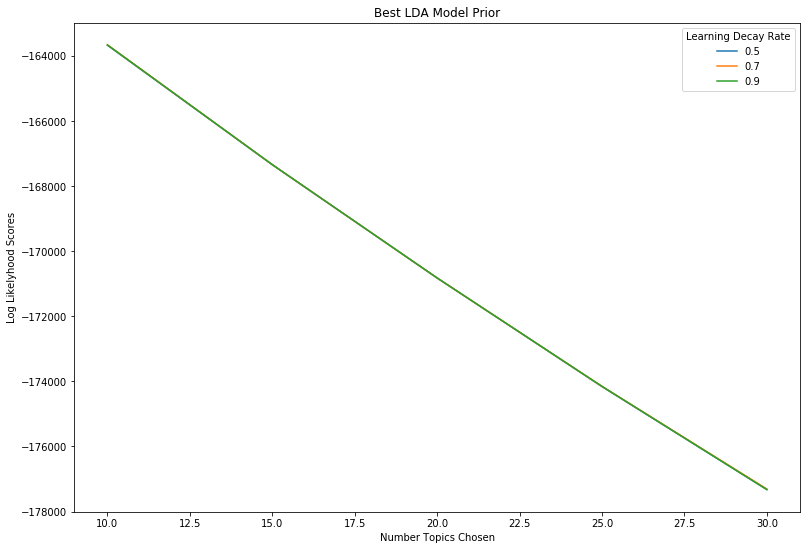

In [76]:
# Log Likelihood diagnostic graph
#need to pull values from the gridsearch
n_topics = [10, 15, 20, 25, 30]
param = model_prior.cv_results_['params']
mean = model_prior.cv_results_['mean_test_score']

log_likelyhoods_5 = [round(mean) for param,mean in zip(param,mean) if param['learning_decay']==0.5]
log_likelyhoods_7 = [round(mean) for param,mean in zip(param,mean) if param['learning_decay']==0.7]
log_likelyhoods_9 = [round(mean) for param,mean in zip(param,mean) if param['learning_decay']==0.9]


plt.figure(figsize=(13, 9))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Best LDA Model Prior")
plt.xlabel("Number Topics Chosen")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning Decay Rate', loc='best')
plt.show()

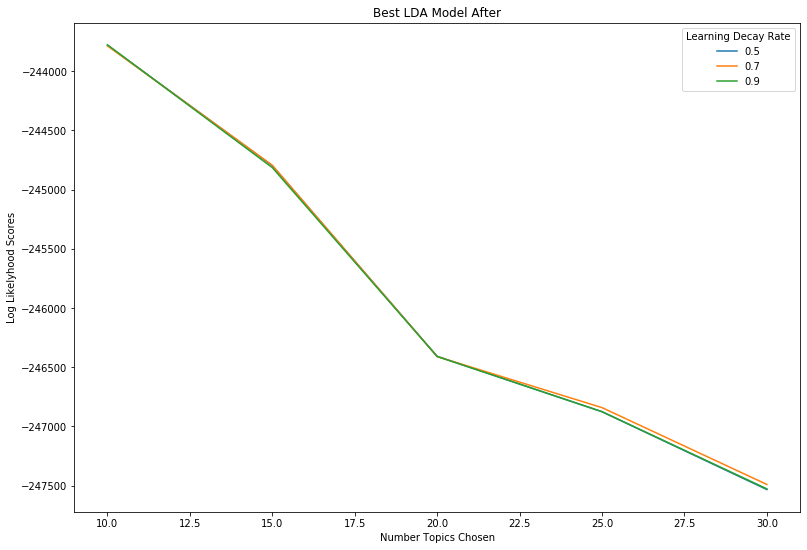

In [77]:
# Log Likelihood diagnostic graph
#need to pull values from the gridsearch
n_topics = [10, 15, 20, 25, 30]
param = model_after.cv_results_['params']
mean = model_after.cv_results_['mean_test_score']

log_likelyhoods_5 = [round(mean) for param,mean in zip(param,mean) if param['learning_decay']==0.5]
log_likelyhoods_7 = [round(mean) for param,mean in zip(param,mean) if param['learning_decay']==0.7]
log_likelyhoods_9 = [round(mean) for param,mean in zip(param,mean) if param['learning_decay']==0.9]

plt.figure(figsize=(13, 9))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Best LDA Model After")
plt.xlabel("Number Topics Chosen")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning Decay Rate', loc='best')
plt.show()

In [112]:
# creating a new LDA model to use with the LDAvis modules
# used number of components as specified in the gridsearch

lda_model_prior = LatentDirichletAllocation(n_components=10,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      learning_decay=.9,
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )

prior_output= lda_model_prior.fit_transform(prior_dtm)



In [114]:
# LDAvis module, outputing in htlm format

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model_prior,prior_dtm, vectorizerp, mds='tsne')
pyLDAvis.save_html(panel, 'lda_before.html')

C:\Users\Chandler Dawson\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [72]:
# creating a new LDA model to use with the LDAvis modules
# used number of components as specified in the gridsearch

lda_model_after = LatentDirichletAllocation(n_components=10,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      learning_decay=.7,
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_model_after.fit(after_dtm)



LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [113]:
# LDAvis module, outputing in htlm format
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model_after, after_dtm, vectorizera, mds='tsne')
pyLDAvis.save_html(panel, 'lda_after.html')

C:\Users\Chandler Dawson\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


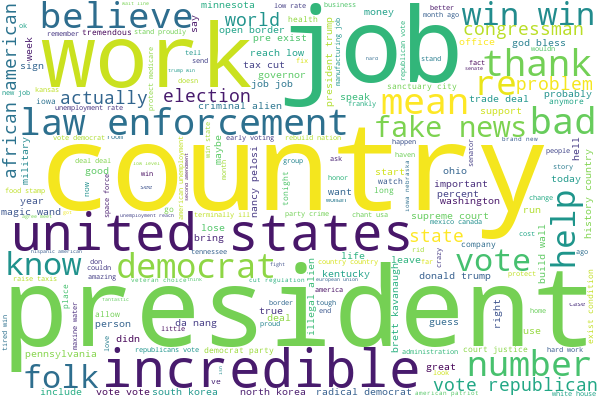

In [109]:

# word cloud object and creation
wordcloud = WordCloud(width=600,height=400,background_color="white", contour_width=3)
wordcloud.generate(prior_string_clean)

wordcloud.to_image()

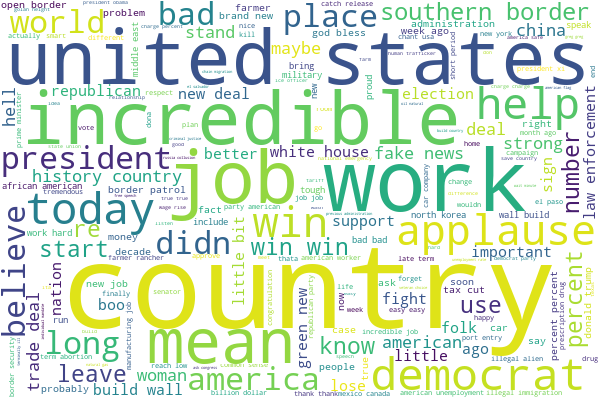

In [110]:
# word cloud object and creation


wordcloud = WordCloud(width=600,height=400,background_color="white", contour_width=3)
wordcloud.generate(after_string_clean)
wordcloud.to_image()